# Monte Carlo Simulation: Stock Price Forecast 

In this notebook, we will forecast the price of Intel Corporation over a period of 60 days. We will use a Monte Carlo simulation to generate different random walk predictions of Intel's price. The data will be split into training data that will contain approximately ten years of daily price history and a test sample of the last 60-day prices of the stock. Then, we will compare the results of the Monte Carlo simulation and the test dataset to evaluate the accuracy and draw conclusions.

Let's start by importing all the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline

Let's also define helpful variables that we will use later to scrap and plot the relevant data. 

In [2]:
stock = 'CAD=X' #Stock ticker symbol
start = '2010-1-1' #Start of the period for the analysis

#Dictionaries to customize the font of labels and titles
label_dict = {'fontsize': 14,
            'fontweight' : 5,
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'
             }
title_dict = {'fontsize': 20,
           'fontweight' : 5,
           'verticalalignment': 'baseline',
           'horizontalalignment': 'center'
             }


Now, we will import the data from yahoo finance using the <code>pandas_datareader</code> library to import the price data. In this case, we will use the Adjusted Close price because this takes into account changes due to stock splits, reverse splits, and dividends.

In [3]:
data = pd.DataFrame()
data[stock] = wb.DataReader(stock, data_source = 'yahoo', start = start)['Adj Close']
    
data.tail()

,CAD=X
Date,
2021-10-10,1.24841
2021-10-11,1.24804
2021-10-12,1.24761
2021-10-13,1.24368
2021-10-14,1.23746


Let's take a look at the relevant information of the data set. As noted below, there are 2,732 observations. All are of float type, and there are no null values. Thus, we don't need to perform any transformation or adjustment to our data set.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3070 entries, 2010-01-01 to 2021-10-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAD=X   3070 non-null   float64
dtypes: float64(1)
memory usage: 48.0 KB


Now, we can take a look at the historical price. The stock has an upward trend that started beginning in 2013. However, we can see the impact of the Covid crash at the beginning of 2020, followed by a recovery that lasted a few months. By July 2020, the stock fell considerably again after the company dropped its revenue forecasts for Q3-2020 and announced delays on new products. 

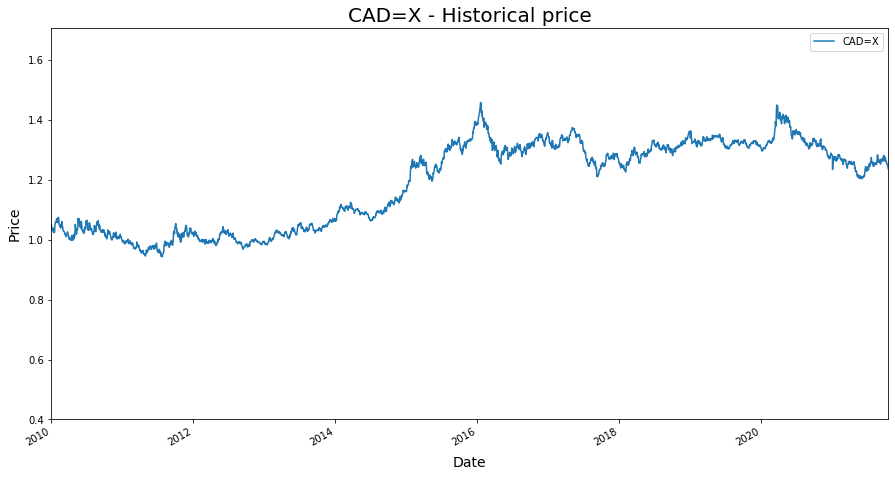

In [5]:
data.plot(xlim=(start,data.index.max()),ylim=(0.4,data.values.max()+0.25),figsize=(15,8))

plt.title(stock + ' - Historical price', fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 19, fontdict = label_dict)

plt.show()

The next step will be to divide our data set into two samples. The <code>data_train</code> variable will be the training set; this set will contain historical price data. This variable will help to fit the model to make the forecast. The <code>data_test</code> variable will be the other subset; this one will have the actual price of the last 60 days. This set will help to evaluate the accuracy of the prediction.

In [6]:
data_train = data.iloc[:-60]
data_test = data.iloc[-60:]

Now, let's calculate the daily returns of the stock. We will use the natural logarithm of the returns because the trend of the stock is exponential growth rather than just linear. The method <code>pct_change</code> will help to calculate the percentual change in the data series. 

In [7]:
Returns = np.log(data_train.pct_change()+1)
Returns.head()

,CAD=X
Date,
2010-01-01,NaN
2010-01-04,-0.009751
2010-01-05,-0.001442
2010-01-06,-0.007338
2010-01-07,0.002033


Taking a look at the graph of the returns, we could see that the mean over the period is relatively stable, constant and close to zero. In the same manner, the volatility of the stock fluctuates in a specific range. We can notice that there are some spikes in volatility; however, these are merely outliers. Based on this analysis, we can conclude that the returns of the stock follow a normal distribution with a stable mean. This conclusion is relevant because it means that we can implement the Brownian Motion model.

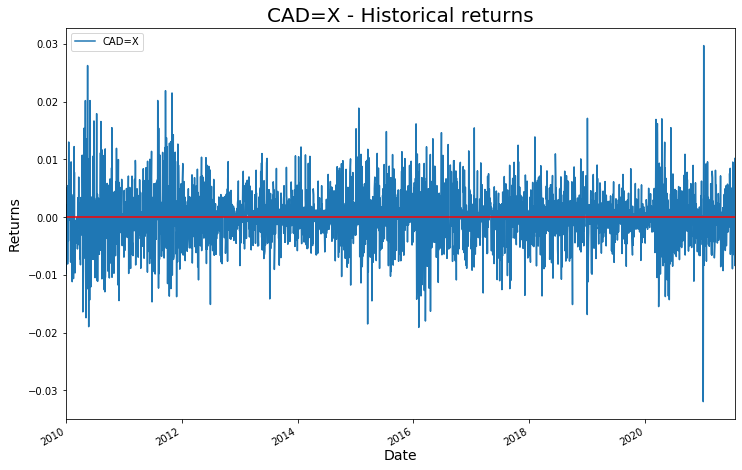

In [8]:
Returns.plot(xlim=(start,Returns.index.max()), figsize=(12,8))

plt.title(stock + ' - Historical returns', fontdict= title_dict)
plt.ylabel('Returns', labelpad = 10, fontdict = label_dict)
plt.xlabel('Date', labelpad = 12, fontdict = label_dict)
plt.axhline(Returns.mean()[0],color='r')

plt.show()

## Brownian movement

The Brownian motion model assumes that the price of the stock follows a random walk. This model implies that future movements of the prices are not related to the past because all information available is already incorporated (a weak form of the efficient markets hypothesis). 

The mathematical representation of the current stock price will be equal to the stock price one period before times the natural logarithm of the returns of the share. This natural logarithm of the returns follows a random process; therefore, we could use the Brownian motion to define it. 

The first component, $\mu - \frac{1}{2}\sigma^2$, represents the drift by what the stock is expected to go up. The second component, $\sigma*Z(Rand(0;1))$, is a random shock that will change the drift either up or down.

\begin{equation*}
\large{Price\ today = Price\ yesterday *  e ^ {\mu - \frac{1}{2}\sigma^2 + \sigma * Z(Rand(0;1))}}
\end{equation*} 

Let's take a look at the mean and standard deviation of the returns.

In [9]:
Mu = Returns.mean()
print(f'The expected return is: %.6f' %Mu[0])

The expected return is: 0.000059


In [10]:
var = Returns.var()
std = Returns.std()
print(f'The variance of the returns is %.5f'%var[0]+' and the standard deviation is %.4f'%std[0])

The variance of the returns is 0.00002 and the standard deviation is 0.0050


With these two parameters, we can calculate the drift component based on the definition above and the following formula:

\begin{equation*}
\large{Drift = \mu - \frac{1}{2}\sigma^2}
\end{equation*} 

In [11]:
drift = Mu - 1/2*var
print(f'The drift component is %.5f'%drift[0])

The drift component is 0.00005


We have all the elements needed to run the model. Now, it is time to run the Monte Carlo simulation. We will generate 50 random trials of the model. Therefore, we will have 50 different possible paths that the returns could follow in the next 60 days. Let's define this into two variables.

In [12]:
t_interval = 60
iterations_1 = 200

Let's create a matrix of daily returns that we will fit with the 50 iterations of the Brownian model.

In [13]:
daily_returns = np.exp(np.array(drift) + 
                       np.array(std) * norm.ppf(np.random.rand(t_interval,iterations_1)))
daily_returns

array([[0.9923297 , 1.00048958, 0.99485144, ..., 0.99560423, 1.00390098,
        0.99787208],
       [1.00190803, 0.99589367, 1.00586741, ..., 0.99908444, 1.00424918,
        0.99836892],
       [0.99565479, 1.00218374, 0.9945006 , ..., 1.00310935, 1.00717306,
        1.00201205],
       ...,
       [0.99537051, 1.00671651, 1.00490852, ..., 0.99511468, 1.00106703,
        1.00361744],
       [1.00569138, 0.99910643, 0.99963231, ..., 1.00133308, 1.00078661,
        0.99614555],
       [1.00276508, 0.99793716, 0.99856193, ..., 0.99976152, 0.9927598 ,
        0.99205209]])

The array above contains all the different predictions of returns. Let's make sure that the result is a matrix of dimension $60$ x $50$.

In [14]:
daily_returns.shape

(60, 200)

Until here, we only have predicted returns. We can calculate the stock price using the chain rule. The chain rule implies that the stock price of the next period will be forecast based on one period before. With this forecast, we can calculate the second period and so on until forecasting the 60th period. Let's assign <code>S0</code> as the price of the last period observed.

In [15]:
S0 = data.iloc[-1]
print(f"Intel's lats price is $%.2f"%S0[0])

Intel's lats price is $1.24


And create a matrix that will store the predicted prices. The dimensions of this matrix have to be the same as the daily returns matrix $60$ x $50$. Let's begin assigning zeros to this matrix.

In [16]:
price_list = np.zeros_like(daily_returns)
price_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The first row of the matrix will correspond to the last price observed, which will be <code>S0</code> for each iteration.

In [17]:
price_list[0] = S0
price_list

array([[1.23746002, 1.23746002, 1.23746002, ..., 1.23746002, 1.23746002,
        1.23746002],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Now, it is time to fill the rest of the matrix with the forecast of each iteration. As mention before, this will be done using the chain rule for forecasting time series, multiplying the last period's stock price times the current return. 

In [18]:
for t in range(1,t_interval):
    price_list[t] = price_list[t-1] * daily_returns[t]

price_list

array([[1.23746002, 1.23746002, 1.23746002, ..., 1.23746002, 1.23746002,
        1.23746002],
       [1.23982113, 1.2323786 , 1.2447207 , ..., 1.23632704, 1.24271821,
        1.23544162],
       [1.23443385, 1.2350698 , 1.23787548, ..., 1.24017122, 1.25163231,
        1.23792739],
       ...,
       [1.1604589 , 1.18879185, 1.24307694, ..., 1.16902237, 1.26454006,
        1.34181446],
       [1.16706351, 1.18772958, 1.24261987, ..., 1.17058077, 1.26553475,
        1.3366425 ],
       [1.17029054, 1.18527948, 1.2408329 , ..., 1.17030161, 1.25637203,
        1.32601899]])

Let's plot the 60 different paths forecasted to have a graphical idea of the price behaviour. 

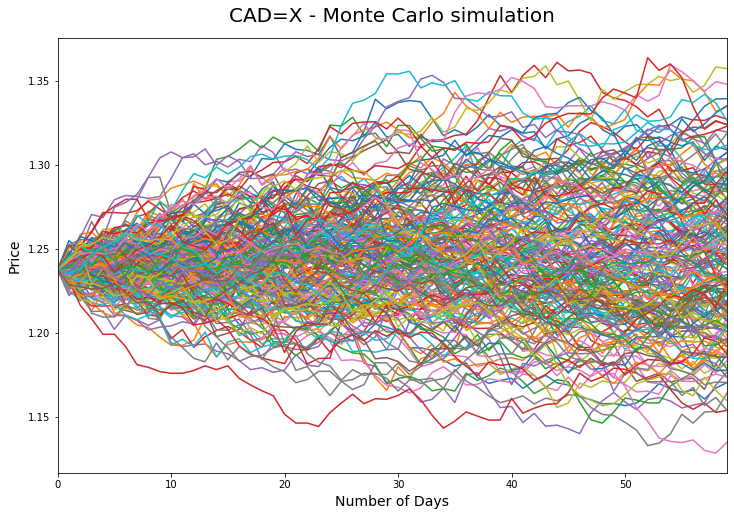

In [19]:
plt.figure(figsize=(12,8))
plt.plot(price_list)

plt.xlim(left = 0,right = t_interval-1)
plt.title(stock  + ' - Monte Carlo simulation',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict = label_dict)

plt.show()

This graph shows all the different paths that the stock price could follow based on our simulation. The chart can give us an idea of the range in which the prediction oscillates. 

A more informative approach will be to estimate relevant statistical parameters from the whole simulation. We can call the <code>describe</code> method to get an insight of the distribution. 

In [20]:
df = pd.DataFrame(price_list)
df1 = pd.concat([pd.DataFrame(df[i].values, columns=[stock]) for i in range(len(df.columns.values))],ignore_index=True)
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CAD=X,12000.0,1.243365,0.033161,1.128337,1.223625,1.240948,1.261399,1.363607


The total number of prices predicted is 3,000. Based on the results, we can conclude that the expected stock price over 60 days will be $45.65. The standard deviation of the price simulation is $4.75. The range in which the stock could move would be between $29.07 - $66.01. Finally, we can say that 25% of the time, the stock price will fall below $42.72, the median of the simulation is $45.30, and 75% of the forecast price would fall below $48.27.

We can take a look at the price distribution plotting a histogram of the results.

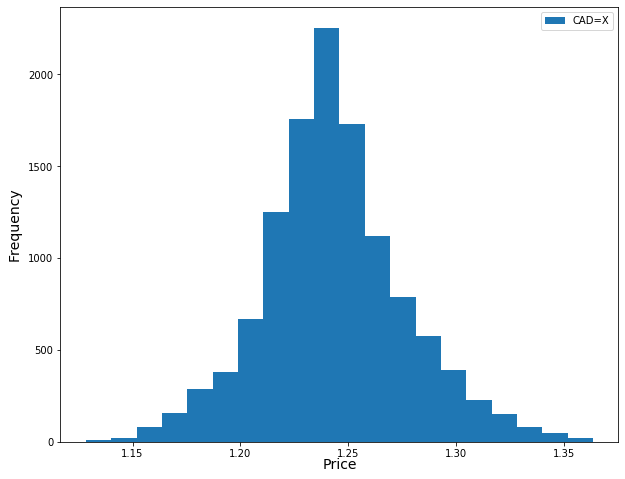

In [21]:
df1.plot.hist(figsize=(10,8),bins=20)
plt.xlabel('Price',labelpad = 10,fontdict = label_dict)
plt.ylabel('Frequency',labelpad = 10,fontdict = label_dict)
plt.show()

From the histogram, we can see that the majority of predictions fall between $40 and $50. Something interesting to notice is that the histogram is positively skewed. This skewness implies that there are more frequent small losses and less frequent excessive gains and that the median is a preferred measure of central tendency than the mean.

Finally, let's try to compare the predicted data with the test sample (or the actual price over the last 60 days). First, we will average for each day the 50 different price predictions and save it in a vector of 59 observations; remember, we lost one data point when calculating the returns. 

In [22]:
pred_price = []

for i in range(1,t_interval):
    pred_price.append(price_list[i].mean())


Plotting the predicted versus the actual price, we can see that the price was considerably over-priced for approximately 50 days. Our median price was $45.3, represented by the red-dotted line, whereas the stock price was trading above $48 and even reaching almost $54 at peak. The probability of the stock being above $48 is approximate 25%. Additionally, the 95th percentile of the simulation is $53.78, which means that a stock price above that value will have a probability of 5%.

The simulation threw a more stable price fluctuation compared to the real price movement. One reason could be that the number of iterations was too large; reducing the number of iteration would add more volatility to the forecast.

By the end of the test set, the stock price is considerable close to what the simulation predicted. Also, both are relatively close to the median price, represented by the blue-dotted line.

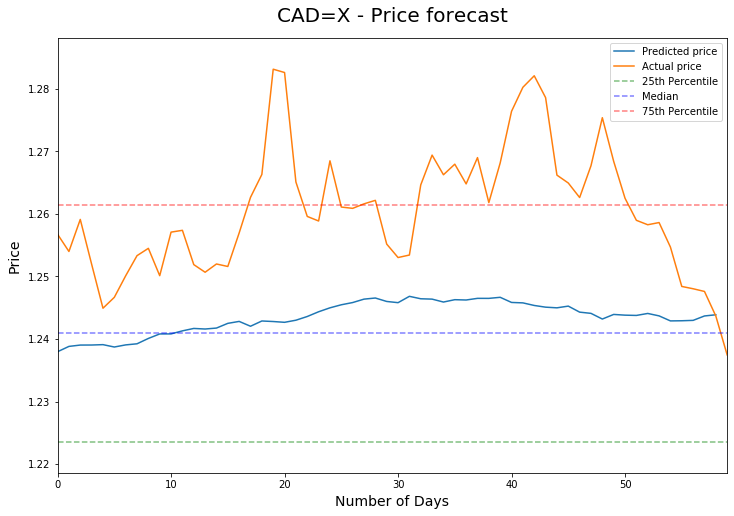

In [23]:
plt.figure(figsize=(12,8))
plt.plot(pred_price,label='Predicted price')
plt.plot(data_test.values,label='Actual price')

plt.axhline(df1.describe().values[4],c='g',label='25th Percentile',alpha=0.5,linestyle='--')
plt.axhline(df1.describe().values[5],c='b',label='Median',alpha=0.5,linestyle='--')
plt.axhline(df1.describe().values[6],c='r',label='75th Percentile',alpha=0.5,linestyle='--')

plt.xlim(left = 0,right = t_interval-1)
plt.ylim(bottom = df1.describe().values[4] - 0.005,top = max(data_test.values) + 0.005)

plt.title(stock + ' - Price forecast',pad = 16, fontdict = title_dict)
plt.ylabel('Price', labelpad = 10, fontdict = label_dict)
plt.xlabel('Number of Days', labelpad = 16, fontdict =label_dict)

plt.legend()
plt.show()

__Conclusion:__ 

The Monte Carlo simulation is useful to estimate a probability distribution of stock prices. With this distribution, an analyst could evaluate if a stock is overvalued, fairly valued, or undervalued. The Monte Carlo simulation can't be taken to a stand-alone decision to buy, hold, or sell a stock. Oher market elements (e.g., high volatile periods) could impact the stock price. 

Further utilization of this prediction could be to estimate an option price. A simulation could be run for a period equal to the maturity of the option and have different stock price paths. Then, a decision tree could be estimated for each price path and estimate the present value of each node in the tree. 

_References:_

- https://www.cnbc.com/2020/07/23/intel-intc-earnings-q2-2020.html
- https://www.investopedia.com/articles/07/montecarlo.asp
- https://www.investopedia.com/terms/r/randomwalktheory.asp
- Career 365. Python for Finance: Investment Fundamentals & Data Analytics [online course]



__Disclaimer:__

The content of this notebook is intended to be used and must be used for informational purposes only. It is very important to do your own analysis before making any investment based on your own personal circumstances. You should take independent financial advice from a professional in connection with, or independently research and verify, any information that you find on this notebook and wish to rely upon, whether for the purposes of making an investment decision or otherwise.

Past performance is not a guarantee of future return, nor is it necessarily indicative of future performance. Keep in mind investing involves risk. The value of your investment will fluctuate over time and you may gain or lose money.